# PDF for the Heston model

In [1]:
import math
import pandas as pd
import datetime, os
import numpy as np
import numpy.random as npr
from pylab import plt, mpl


from scipy.stats import norm
from scipy import optimize
import scipy.integrate as integrate
import scipy.special as special 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import quad

from scipy.interpolate import BSpline, make_interp_spline, CubicSpline


In [2]:
def heston_call(S, K, tau, r, kappa, theta, sigma, rho, nu, limit):
    X = np.log(S / K)
    kappahat = kappa - 0.5 * rho *sigma

    def Integrand(k):
        xi = np.sqrt(k**2*sigma**2*(1-rho**2) + 2j*k*sigma*rho*kappahat + \
                         kappahat**2 + (sigma**2)/4)
        psi_p = -(1j*k*rho*sigma + kappahat) + xi
        psi_m = (1j*k*rho*sigma + kappahat) + xi
        alpha = -((kappa*theta)/sigma**2) * \
              (psi_p*tau + 2*np.log((psi_m+psi_p*np.exp(-xi*tau))/(2*xi)))
        beta = (1-np.exp(-xi*tau)) / (psi_m + psi_p * np.exp(-xi*tau))

        numerator = np.exp((-1j*k+0.5)*X+alpha-(k**2+0.25)*beta*nu)
        integrall = np.real(numerator / (k**2+0.25))

        return integrall

    result = integrate.quad(lambda x: Integrand(x), -limit, limit)
    integrall = result[0]

    # compute Call price
    price = 1*S-K*np.exp(-r*tau)*integrall / (2*np.pi)

    return price

In [3]:
class bsm_call_option(object):
    '''
    Class for European call options in BSM model
    It's main purpose is calculating the implied volatility for the Heston model
    
    Attributes
    ==========
    S: float - Stock price
    K: float - Strike price
    tau: float - time to maturity 
    r: float - constant riske-free rate
    sigma: float - volatility
    '''
    
    def __init__(self, S, K, tau, r, sigma):
        self.S = S
        self.K = K
        self.tau = tau
        self.r = r
        self.sigma = sigma
        
    def value(self):
        d1 = ((np.log(self.S / self.K) +
               (self.r + 0.5 * self.sigma ** 2) * self.tau) /
              (self.sigma * np.sqrt(self.tau)))
        d2 = ((np.log(self.S / self.K) +
               (self.r - 0.5 * self.sigma ** 2) * self.tau) /
              (self.sigma * np.sqrt(self.tau)))
        value = (self.S * norm.cdf(d1, 0.0, 1.0) -
                 self.K * np.exp(-self.r * self.tau) * norm.cdf(d2, 0.0, 1.0))
        return value
    
def bisection(S,K,tau,r,C0, it=10000, precision=1e-6):
    #lower bound and upper bound definition
    a = 1e-20
    b = 10
    m = (b+a) / 2
    count_iter = 1

    while count_iter <= it and math.fabs(b-a)>precision:
        #If f(a)*f(b)<0
        if (bsm_call_option(S, K, tau, r, a).value()-C0)*(bsm_call_option(S, K, tau, r, m).value()-C0)<0:
            b = m
        else:
            a = m
        m = (b+a) / 2
        count_iter += 1
    return m


In [4]:
K = np.arange(0.8, 1.3, 0.05)

S, theta, r, kappa, rho, nu, tau, sigma =1, 0.373747, 0.045702, 1.042103, -0.617528, 0.47395, 0.1219, 0.443298

#integrate from -400 to 400 for ease of computation in heston
limit = 400

hc = np.vectorize(heston_call)
bs = np.vectorize(bisection)

#Initialize the implied volatility matrix with zeros
imp_vol = np.zeros(10)

#Create the implied volatilities
for i in range(len(K)):
    imp_vol[i] = bs(S, K[i], tau, r, hc(S, K[i], tau, r, kappa, theta, sigma, rho, nu, limit))

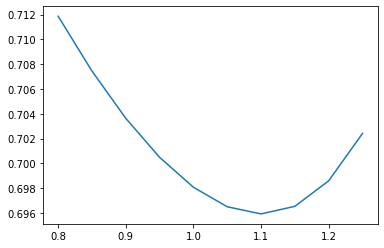

In [5]:
plt.plot(K, imp_vol)

Interpolate

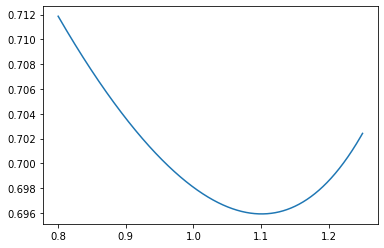

In [6]:
x = np.linspace(min(K), max(K), 5000)
cs = CubicSpline(K, imp_vol)
y = cs(x)

plt.plot(x, y)

## PDF

In [7]:
# Lets use forward difference formula (numerical differenttiation)
# first order
dyforward = [0.0] * len(x)
for i in range(len(y) - 1):
    dyforward[i] = (y[i+1] - y[i]) / (x[i+1] - x[i])
    #for the last data point we use backward differentiation
dyforward[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])
# second order
dyforward2 = [0.0] * len(x)
for i in range(len(y) - 2):
    dyforward2[i] = (y[i] - 2*y[i+1] + y[i+2]) / ((x[i+1] - x[i])**2)
    #for the last data point we use backward differentiation
dyforward2[-1] = (y[-1] - 2*y[-2] + y[-3]) / ((x[-1] - x[-2])**2)
    
pdf = []
for i in range(len(x)):
    d1 = (np.log(S/x[i])+(r+0.5*sigma**2)*(tau))/(sigma*np.sqrt(tau))
    d2 = (np.log(S/x[i])+(r-0.5*sigma**2)*(tau))/(sigma*np.sqrt(tau))
    nd2 = norm.cdf(d2, 0.0, 1.0)
        
    
    PDF = nd2 * (1/(y[i]*x[i]*np.sqrt(tau)) + ((2*d1)/y[i])*dyforward[i] +
                 ((d1*d2*x[i]*np.sqrt(tau))/y[i])*dyforward[i]**2 + x[i]*np.sqrt(tau)*dyforward2[i])
    pdf.append(PDF)

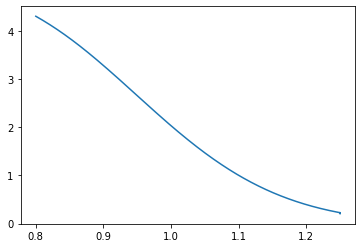

In [8]:
plt.plot(x, pdf)